In [1]:
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import backend as K
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
print('TensorFlow:', tf.__version__)
print('Executing eagerly:', tf.executing_eagerly())

TensorFlow: 1.15.0
Executing eagerly: False


In [2]:
h, w = 720, 1280

In [3]:
def run(op):
    with tf.Session() as sess:
        return sess.run(op)
    
def imshow(image):
    plt.figure(figsize=(16, 9))
    plt.axis('off')
    plt.imshow(image)
    
    
def draw_boxes_cv2(image, bbox_list, model_input_shape=[h, w]):
    img = np.uint8(image).copy()
    bbox_list = np.array(bbox_list, dtype=np.int32)
    h, w = img.shape[:2]
    h_scale, w_scale = h / model_input_shape[0], w / model_input_shape[1]
    bbox_list = np.int32(bbox_list * np.array([w_scale, h_scale] * 2))
    for box in bbox_list:
        img = cv2.rectangle(img, (box[0], box[1]),
                            (box[2], box[3]), [30, 15, 200], 2)
    return img    

In [4]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'xmins': tf.io.VarLenFeature(tf.float32),
    'ymins': tf.io.VarLenFeature(tf.float32),
    'xmaxs': tf.io.VarLenFeature(tf.float32),
    'ymaxs': tf.io.VarLenFeature(tf.float32),
    'labels': tf.io.VarLenFeature(tf.float32)
}


def parse_example(example_proto):
    parsed_example = tf.io.parse_single_example(
        example_proto, feature_description)
    image = tf.image.decode_jpeg(parsed_example['image'], channels=3)
    bboxes = tf.stack([
        tf.sparse.to_dense(parsed_example['xmins']),
        tf.sparse.to_dense(parsed_example['ymins']),
        tf.sparse.to_dense(parsed_example['xmaxs']),
        tf.sparse.to_dense(parsed_example['ymaxs'])
    ], axis=-1)
    class_ids = tf.reshape(tf.sparse.to_dense(
        parsed_example['labels']), [-1, 1])
    return image, bboxes, class_ids

def compute_area(boxes):
    h_ = boxes[:, 2] - boxes[:, 0]
    w_ = boxes[:, 3] - boxes[:, 1]
    return h_ * w_


def load_data(example_proto):
    image, boxes_, class_ids = parse_example(example_proto)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, size=[h, w])
    boxes = tf.stack([
        tf.clip_by_value(boxes_[:, 0] * w, 0, w),
        tf.clip_by_value(boxes_[:, 1] * h, 0, h),
        tf.clip_by_value(boxes_[:, 2] * w, 0, w),
        tf.clip_by_value(boxes_[:, 3] * h, 0, h)
    ], axis=-1)
    label = tf.concat([boxes, class_ids], axis=-1)
    return image, label

tf_records_pattern = os.environ['HOME'] + '/datasets/BDD100k' + '/train_0000.tfrecords'
autotune = tf.data.experimental.AUTOTUNE
train_files = tf.data.Dataset.list_files(tf_records_pattern)
dataset = train_files.interleave(tf.data.TFRecordDataset,
                                 cycle_length=16,
                                 block_length=16,
                                 num_parallel_calls=autotune)
dataset = dataset.map(load_data, num_parallel_calls=autotune)
dataset = dataset.make_one_shot_iterator()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


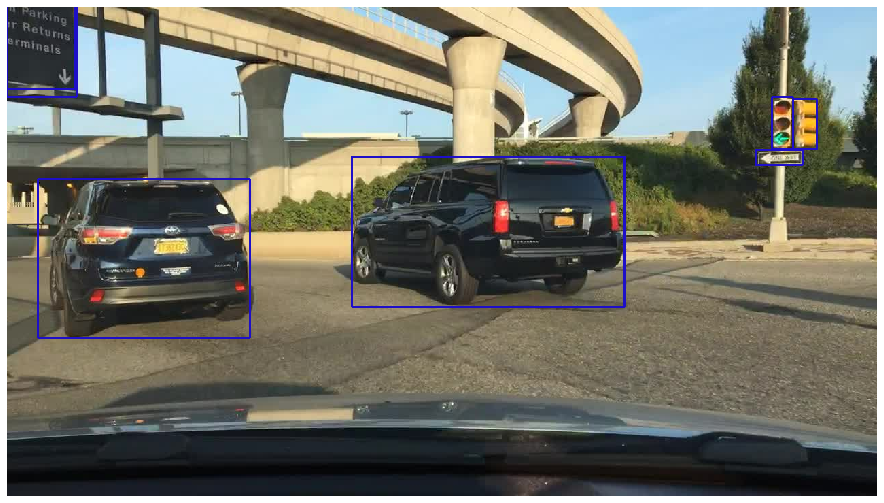

In [5]:
batch = run(dataset.get_next())
labels = batch[1]
image = batch[0]
imshow(draw_boxes_cv2(image, labels[:, :4]))

In [6]:
def get_centers(level, h, w):
    stride = tf.cast(tf.pow(2, level), dtype=K.floatx())
    fm_h = tf.math.ceil(h / stride)
    fm_w = tf.math.ceil(w / stride)
    rx = (tf.range(fm_w, dtype=K.floatx()) + 0.5) * (stride)
    ry = (tf.range(fm_h, dtype=K.floatx()) + 0.5) * (stride)
    sx, sy = tf.meshgrid(rx, ry)
    cxy = tf.stack([sx, sy], axis=-1)
    cxy = tf.reshape(cxy, shape=[-1, 2])
    return cxy


def compute_target_(level, boxes, class_ids, low, high, h, w):
    centers = get_centers(level, h, w)  # (M, 2)

    xy_min_ = boxes[:, :2]  # (N, 2)
    xy_max_ = boxes[:, 2:]  # (N, 2)
    lt_ = tf.expand_dims(centers, axis=1) - xy_min_  # (M, N, 2)
    rb_ = xy_max_ - tf.expand_dims(centers, axis=1)  # (M, N, 2)
    ltrb_ = tf.concat([lt_, rb_], axis=2)  # (M, N, 4)

    # check if max(lbtr) lies in the valid_range for this
    # feature level
    max_ltrb_ = tf.reduce_max(ltrb_, axis=2)  # (M, N)
    mask_size = tf.logical_and(tf.greater(max_ltrb_, low),
                          tf.less(max_ltrb_, high))  # (M, N)
    
    mask = tf.cast(tf.greater(ltrb_, 0), dtype=K.floatx())  # (M, N, 4)
    mask = tf.not_equal(tf.reduce_prod(mask, axis=2), 0.)   # (M, N)
    mask = tf.logical_and(mask, mask_size)   # (M, N)
    mask = tf.cast(mask, dtype=K.floatx())  # (M, N)
    
    fg_mask = tf.not_equal(tf.reduce_sum(mask, axis=1), 0)  # (M, )
    fg_mask = tf.cast(fg_mask, dtype=K.floatx())  # (M, )

    valid_indices = tf.argmax(mask, axis=1)  # (M, )
    matched_boxes = tf.gather(boxes, valid_indices)
    matched_class_ids = tf.gather(class_ids, valid_indices) + 1

    x_min, y_min, x_max, y_max = tf.split(matched_boxes,
                                          num_or_size_splits=4,
                                          axis=1)
    l = tf.abs(centers[:, 0] - x_min[:, 0])  # (M, )
    t = tf.abs(centers[:, 1] - y_min[:, 0])  # (M, )
    r = tf.abs(x_max[:, 0] - centers[:, 0])  # (M, )
    b = tf.abs(y_max[:, 0] - centers[:, 1])  # (M, )
    lr = tf.stack([l, r], axis=1)  # (M, 2)
    tb = tf.stack([t, b], axis=1)  # (M, 2)

    min_lr = tf.reduce_min(lr, axis=1)  # (M, )
    max_lr = tf.reduce_max(lr, axis=1)  # (M, )
    min_tb = tf.reduce_min(tb, axis=1)  # (M, )
    max_tb = tf.reduce_max(tb, axis=1)  # (M, )

    classification_target = matched_class_ids * fg_mask
    centerness_target = tf.sqrt(
        (min_lr / max_lr) * (min_tb / max_tb)) * fg_mask
    regression_target = tf.stack(
        [l, t, r, b], axis=1) * tf.expand_dims(fg_mask, axis=1)
    normalizer_value = tf.reduce_sum(fg_mask)
    return (classification_target,
            centerness_target,
            regression_target,
            fg_mask, 
            normalizer_value)

def compute_targets(labels, h, w):
    boxes_ = labels[:, :4]  # (N, 4)
    class_ids_ = labels[:, 4]  # (N, 1)
    # Sorted the boxes by area in ascending order so that
    # we pick the smallest box when computing ltbr values
    
    areas = compute_area(boxes_)
    sorted_indices = tf.argsort(areas, direction='DESCENDING')
    boxes = tf.gather(boxes_, indices=sorted_indices)
    class_ids = tf.gather(class_ids_, indices=sorted_indices)

    P3_target = compute_target_(3, boxes, class_ids, 0, 64, h, w)
    P4_target = compute_target_(4, boxes, class_ids, 64, 128, h, w)
    P5_target = compute_target_(5, boxes, class_ids, 128, 256, h, w)
    P6_target = compute_target_(6, boxes, class_ids, 256, 512, h, w)
    P7_target = compute_target_(7, boxes, class_ids, 512, 1e8, h, w)
    return {
        'P3': P3_target,
        'P4': P4_target,
        'P5': P5_target,
        'P6': P6_target,
        'P7': P7_target
    }

def load_data(example_proto):
    image, boxes_, class_ids = parse_example(example_proto)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, size=[h, w])
    boxes = tf.stack([
        tf.clip_by_value(boxes_[:, 0] * w, 0, w),
        tf.clip_by_value(boxes_[:, 1] * h, 0, h),
        tf.clip_by_value(boxes_[:, 2] * w, 0, w),
        tf.clip_by_value(boxes_[:, 3] * h, 0, h)
    ], axis=-1)
    labels = tf.concat([boxes, class_ids], axis=-1)
    targets = compute_targets(labels, h, w)
    return image, targets

In [7]:
tf_records_pattern = os.environ['HOME'] + '/datasets/BDD100k' + '/train_0000.tfrecords'
autotune = tf.data.experimental.AUTOTUNE
train_files = tf.data.Dataset.list_files(tf_records_pattern)
dataset = train_files.interleave(tf.data.TFRecordDataset,
                                 cycle_length=16,
                                 block_length=16,
                                 num_parallel_calls=autotune)
dataset = dataset.map(load_data, num_parallel_calls=autotune).batch(8)
dataset = dataset.make_one_shot_iterator()

In [8]:
iterate_op = dataset.get_next()
for i in tqdm(range(200)):
    batch = run(iterate_op)